## Starbucks Customer Analysis
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset provided here was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

The task here is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

### Import libraries

In [6]:
from itertools import combinations
from test_results import test_results, score
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, recall_score, f1_score, make_scorer, confusion_matrix, recall_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import sklearn as sk
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### I. The Data

#### I.1 Overview of the Data

In [7]:
# LOADING THE DATA
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


- only 1 feature clearly defined as categorical -> promotion
- the other ones seem to be numerical.

In [9]:
def get_percent_missing_values_features(df):
    '''
    this function returns the percentage of missing value for a specific variable.
    Args:
        feature: the feature / column from DataFrame.
    Returns:
        /
    '''
    for feature in df.columns:
        missing_values = len(df[df[feature].isnull()])
        total_length = len(df[feature])
        print("[Feature '{}'] percentage missing values: {}% ({}/{})\n".format(feature, round(100 * missing_values/total_length,2), missing_values, total_length ))

In [10]:
get_percent_missing_values_features(train_data)

[Feature 'ID'] percentage missing values: 0.0% (0/84534)

[Feature 'Promotion'] percentage missing values: 0.0% (0/84534)

[Feature 'purchase'] percentage missing values: 0.0% (0/84534)

[Feature 'V1'] percentage missing values: 0.0% (0/84534)

[Feature 'V2'] percentage missing values: 0.0% (0/84534)

[Feature 'V3'] percentage missing values: 0.0% (0/84534)

[Feature 'V4'] percentage missing values: 0.0% (0/84534)

[Feature 'V5'] percentage missing values: 0.0% (0/84534)

[Feature 'V6'] percentage missing values: 0.0% (0/84534)

[Feature 'V7'] percentage missing values: 0.0% (0/84534)



The DataFrame has no missing values.

In [11]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


- V1, V4, V5, V6, V7 are actually categorical features. It could be find out thanks to the max value.
- it looks like V2 shows some extrem values. It will be checked later.

#### I.2 Categorical features

In [12]:
# CATEGORICAL FEATURES

cat_features = ['V1', 'V4', 'V5', 'V6', 'V7']

for feature in cat_features:
    print(train_data[feature].value_counts())
    print("\n")

1    31631
2    31608
3    10670
0    10625
Name: V1, dtype: int64


2    57450
1    27084
Name: V4, dtype: int64


3    32743
2    31196
1    15412
4     5183
Name: V5, dtype: int64


3    21186
4    21176
2    21146
1    21026
Name: V6, dtype: int64


2    59317
1    25217
Name: V7, dtype: int64




In [13]:
# CREATING DUMMIES VARIABLES FOR THE CATEGORICAL VARIABLES

for feature in cat_features:
    df_dummies = pd.get_dummies(train_data[feature]).rename(columns=lambda x: feature + "_" + str(x))
    train_data = pd.concat([train_data, df_dummies], axis=1)
    train_data = train_data.drop(feature, axis=1)

print(train_data.head())

   ID Promotion  purchase         V2        V3  V1_0  V1_1  V1_2  V1_3  V4_1  \
0   1        No         0  30.443518 -1.165083     0     0     1     0     1   
1   3        No         0  32.159350 -0.645617     0     0     0     1     0   
2   4        No         0  30.431659  0.133583     0     0     1     0     1   
3   5        No         0  26.588914 -0.212728     1     0     0     0     0   
4   8       Yes         0  28.044332 -0.385883     0     0     0     1     1   

   ...  V5_1  V5_2  V5_3  V5_4  V6_1  V6_2  V6_3  V6_4  V7_1  V7_2  
0  ...     1     0     0     0     0     0     1     0     0     1  
1  ...     0     0     1     0     0     1     0     0     0     1  
2  ...     1     0     0     0     0     0     0     1     0     1  
3  ...     1     0     0     0     0     0     0     1     0     1  
4  ...     1     0     0     0     0     1     0     0     0     1  

[5 rows x 21 columns]


#### I.3 Numerical features

In [14]:
def diagnostics_plot(df, feature):
    '''
    Function to plot a histogram and a Q-Q plot side by side 
    for a specific variable.
    Args:
        df: the DataFrame
        feature: the variable to consider
    Returns:
        /
    '''
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist='norm', plot=plt)
    #plt.show()

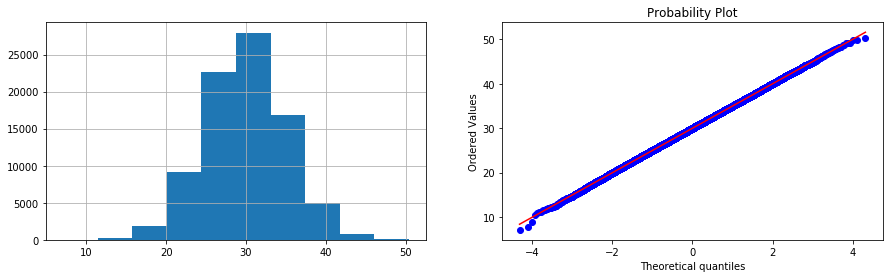

In [15]:
# DISTRIBUTION OF "V2"

diagnostics_plot(train_data, "V2")

The distribution of V2 is perfectly normale and centered in x=30. Actually, there is maybe no need to cut extrem values on both side.

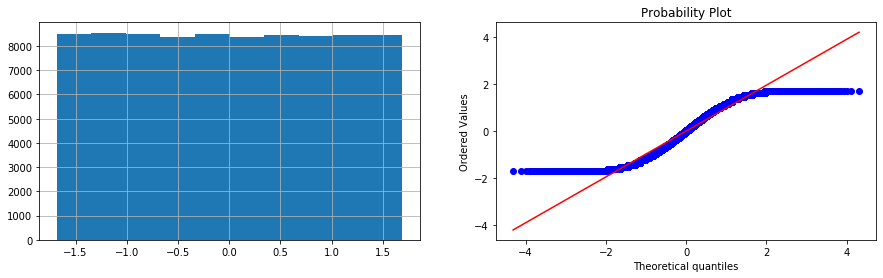

In [16]:
# DISTRIBUTION OF V3

diagnostics_plot(train_data, "V3")

The variable 'V3' is uniformed distributed.

### II. The Metrics

#### II.2 Invariant metric

In [17]:
# TOTAL NUMBER OF OBSERVED
cust_obs = train_data.shape[0]

# FINDING TOTAL NUMBER OF CUSTOMER IN PROMOTION / NOT IN PROMOTION
cust_treat_df = train_data[train_data['Promotion'] == 'Yes']
cust_ctrl_df = train_data[train_data['Promotion'] == 'No']

cust_treat = cust_treat_df.shape[0]
cust_ctrl = cust_ctrl_df.shape[0]

# FINDING TOTAL NUMBER OF PURCHASER IN PROMOTION / NOT IN PROMOTION

purch_treat = cust_treat_df[cust_treat_df["purchase"] == 1].shape[0]
purch_ctrl = cust_ctrl_df[cust_ctrl_df["purchase"] == 1].shape[0]

print("Number of customers in experiment: {} / Purchaser: {}".format(cust_treat, purch_treat))
print("Number of customers not in experiment: {} / Purchaser: {}".format(cust_ctrl, purch_ctrl))

Number of customers in experiment: 42364 / Purchaser: 721
Number of customers not in experiment: 42170 / Purchaser: 319


There is a larger number of customer taking part in the experiment group than not.

In [18]:
# COMPUTING A P-VALUE AND Z-VALUE

p = 0.5
sd = np.sqrt(p * (1-p) * cust_obs)

z = ((cust_ctrl + 0.5) - p * cust_obs) / sd

print("z-value: {}".format(z))
print("p-value: {}".format(2 * stats.norm.cdf(z)))

z-value: -0.6638066506192843
p-value: 0.5068140685419046


This ends up generating a p-value of 0.506 (z = -0.66), which is within a reasonable range under the null hypothesis. Since we lack sufficient reason to reject the null, we can continue on to evaluating the evaluation metrics.

#### II.2 Evaluation metrics

##### Incremental Response Rate (IRR)

In [19]:
irr = purch_treat/cust_treat - purch_ctrl/cust_ctrl
print("IRR: {}".format(irr))

IRR: 0.009454547819772702


Slighty, the promotion increases the number of purchasers. The Incremental Response Rate is below 1% so it means the promotion was not so efficient.

##### Net Incremental Revenue (NIR)

In [20]:
nir = (10 * purch_treat - 0.15 * cust_treat) - 10 * purch_ctrl
print("NIR: {}".format(nir))

NIR: -2334.5999999999995


Because either the number of people in the experiment was too low or the people aimed are not the right ones, the Net Incremental Revenue is negative which means basically the promotion was not good enough.

These results came from the training data set. Let's consider now that we send to everyone the promotion (most costly option and basic model)

In [21]:
#INITIAL PROMOTION STATREGY
# -> EVERYONE RECEIVES THE PROMOTION

def promotion_strategy(df):
    '''
    Args: 
        df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    Returns:
        promotion_df - np.array with the values
                       'Yes' or 'No' related to whether or not an 
                       individual should recieve a promotion 
                       should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = []
    
    num_test_points = df.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [22]:
# THIS FUNCTION TESTS THE RESULTS OF THE PROMOTION STRATEGY.

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

Giving the promotion to everyone seems to bring better results than it is shown in the training data set.
- IRR = 0.96%
- NIR = -1132 $

However, it will definitively cost a lot the company to do it. The number of promotions sent are cust_obs = 84534.

Our desired minimum IRR is 1.5% (an 0.081\% absolute increase in IRR from previous value), and we want to detect this change with a type 1 error rate of 5% and a power of 80%.
We need then to find out the size of our data (actually number of customers) to be able to do it.

In [23]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

NormalIndPower().solve_power(effect_size = proportion_effectsize(0.0096, .015), alpha = .05, power = 0.8,
                             alternative = 'smaller')

5089.265513625437

5089 entries are enough. Our DataFrame shows us 84534. We have enough data to implement models and to reach the goal.

# III. The Models

We are interested in finding the best customers who are likely to purchase. Understanding the profile of the customer will help to determinate if a promotion should be sent or not.

## III. I. Considering 2 models; customers in the promotion / not in promotion

Our first approach would be to train 2 models.

- on the customers involved in the experiment (promotion), and finding out its profile to purchase.
- on the customers not involved in the promotion, and finding out its profile to purchase.

2 kinds of profiles are then defined. The models try to predict if the customer will purchase or not.

Ideally the difference in the probabilities, which we will call the lift:

$$ Lift = P(purchase | treatment) - P(purchase | control) $$

will tell us the probability that sending a promotion to an individual will increase his or her willingness to make a purchase vs not sending a promotion. We can then send promotions to individuals with lift values higher than a pre-defined cutoff percentile. For example, we can send promotions to individuals in the top 3 deciles.

For this dataset, we can manually try a few cutoff percentiles or perform a grid search to find the optimal cut-off percentile.

In [24]:
# CONSIDERING THE 2 DATAFRAMES
cust_treat_df = train_data[train_data['Promotion'] == 'Yes']
cust_ctrl_df = train_data[train_data['Promotion'] == 'No']

In [25]:
print("[Treatement] Number of purchase: {}/{}".format(cust_treat_df[cust_treat_df['purchase']==1].shape[0],len(cust_treat_df)))
print("[Control] Number of purchase: {}/{}".format(cust_ctrl_df[cust_ctrl_df['purchase']==1].shape[0],len(cust_ctrl_df)))

[Treatement] Number of purchase: 721/42364
[Control] Number of purchase: 319/42170


The data is inbalanced, there is largely more "no purchase" than "yes purchase". The classification from our models won't work.
We have to use common techniques to balance the data.
We will use here the SMOTE method.

SMOTE is an over-sampling method. What it does is, it creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class. SMOTE does this by selecting similar records and altering that record one column at a time by a random amount within the difference to the neighbouring records.

In [26]:
features = ['V2', 'V3', 'V1_0', 'V1_1', 'V1_2',
            'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2',
            'V5_3', 'V5_4', 'V6_1', 'V6_2','V6_3',
            'V6_4', 'V7_1', 'V7_2']

# X,y ON MODEL PROMOTION
X_treat = cust_treat_df[features]
y_treat = cust_treat_df['purchase']

# X,y ON MODEL NO PROMOTION
X_ctrl = cust_ctrl_df[features]
y_ctrl = cust_ctrl_df['purchase']

# SPLITTING DATA INTO TRAIN/VALIDATE DATAFRAMES FOR BOTH MODELS
X_treat_train, X_treat_test, y_treat_train, y_treat_test = train_test_split(X_treat, y_treat, test_size=0.3, random_state=10)
X_ctrl_train, X_ctrl_test, y_ctrl_train, y_ctrl_test = train_test_split(X_ctrl, y_ctrl, test_size=0.3, random_state=10)

In [27]:
# BALANCING THE DATA
smt = SMOTE()

# FOR THE TREATEMENT MODEL
X_treat_train, y_treat_train = smt.fit_sample(X_treat_train, y_treat_train)
X_treat_train = pd.DataFrame(X_treat_train, columns=features)
y_treat_train = pd.Series(y_treat_train)

# FOR THE CONTROL MODEL
X_ctrl_train, y_ctrl_train = smt.fit_sample(X_ctrl_train, y_ctrl_train)
X_ctrl_train = pd.DataFrame(X_ctrl_train, columns=features)
y_ctrl_train = pd.Series(y_ctrl_train)

In [28]:
y_treat_train.value_counts()

1    29156
0    29156
Name: purchase, dtype: int64

The Data is equaly blanced now.

Thanks to the [Sklearn model section hint](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), our first model to be used will be a LinearSVC model.


Even if finding out who can buy is our target, ensuring also that we don't send a promotion to someone who is not willing to buy is crucial as it would be costly for the company. As the likelihood seems to be clearly not a purchaser, I establish a balanced accuracy optimizer scorer function where 80% of the result is focus on finding right non purchasers (false positive has an important weigh of loss). Specificity will be used as criteria to find the best model.

In [ ]:
def scorer_optim(y_true, y_pred):
    '''
    Scorer function for our models.
    Args: 
        y_true: DataFrame of true values.
        y_pred: DataFrame of predicted values.
    Return:
        b_acc + spe + rec: scorer value
    '''
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # BALANCED_ACCURACY SCORE 
    b_acc = balanced_accuracy_score(y_true, y_pred) * 0.05
    
    # SPECIFICITY - FALSE POSITIVE
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.8
    
    # RECALL 
    rec = recall_score(y_true, y_pred) * 0.15
    
    # IMPERFECT SPECIFICITY WILL LOOSE A PENALTY
    # THIS MEANS THE BEST RESULTS WILL HAVE PERFECT SPECIFICITY AND COMPETE FOR RECALLS AND BALANCED ACCURARY
    if spe < 0.8:
        spe -= 0.2
    return b_acc + spe + rec

In [29]:
# AS THE DATA IS IMBALANCED, DEFINING A CUSTOM SCORER FUNCTION BASED ON SPECIFICITY

def scorer_optim(y_true, y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # BALANCED_ACCURACY SCORE 
    b_acc = balanced_accuracy_score(y_true, y_pred) * 0.05
    
    # SPECIFICITY - FALSE POSITIVE
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.8
    
    # RECALL 
    rec = recall_score(y_true, y_pred) * 0.15
    
    # IMPERFECT SPECIFICITY WILL LOOSE A PENALTY
    # THIS MEANS THE BEST RESULTS WILL HAVE PERFECT SPECIFICITY AND COMPETE FOR RECALLS AND BALANCED ACCURARY
    if spe < 0.8:
        spe -= 0.2
    return b_acc + spe + rec

#SCORERS FOR OUR MODELS
optimize = make_scorer(scorer_optim)
b_acc = make_scorer(balanced_accuracy_score)

def score_optimization(model, params, clf, X_train, y_train, X_test, y_test):
    
    start = time()
    
    # CREATING PIPELINE
    pipeline_model = Pipeline([
        ('scaler', StandardScaler()),
        #('scaler', MinMaxScaler()),
        ('clf',  clf )
    ])
    
    # LOADING GRIDSEARCH CV
    search = GridSearchCV(
        pipeline_model,
        params,
        n_jobs=1,
        scoring=optimize
    )

    # TRAIN SEARCH OBJECT
    search.fit(X_train, y_train)
    
    # HEADING
    print('\n','-'*40,'\n', model.upper() + " MODEL",'\n','-'*40)
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

    # EXTRACTING BEST ESTIMATOR
    best = search.best_estimator_
    print('Best parameters: \n\n',search.best_params_,'\n')

    # CROSS-VALIDARE ON THE TRAIN DATA
    print("TRAIN GROUP")
    train_cv = cross_val_score(X=X_train, y=y_train, 
                               estimator=best, scoring=b_acc,cv=3)
    print("\nCross-validation recall scores:",train_cv)
    print("Mean balanced accuracy score:",train_cv.mean())

    # NOW PREDICT ON THE TEST GROUP
    print("\nTEST GROUP")
    y_pred = best.fit(X_train, y_train).predict(X_test)
    print("\nBalanced Accuracy Score:",balanced_accuracy_score(y_test,y_pred),"\n")

    # GET CLASSIFICATION REPORT
    print(classification_report(y_test, y_pred))

    # PRINT CONFUSION MATRIX
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # STORE RESULTS
    performance.loc[clf.__class__.__name__+ "_" + model.lower(),:] = [
        train_cv.mean(),
        balanced_accuracy_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum(),
        recall_score(y_test,y_pred),
        scorer_optim(y_test,y_pred)
    ]
    # DISPLAYING RESULTS
    display(pd.DataFrame(search.cv_results_).iloc[:,4:].sort_values(by='rank_test_score').head())
    display(performance)
    
    end = time()
    print("Executed time: {}s".format(round(end - start,2)))
    return best
    
# DATAFRAME TO STORE CLASSIFIER PERFORMANCE
performance = pd.DataFrame(columns=['Train_Balanced_Accuracy', 'Test_Balanced_Accuracy', 'Test_Specification', 'Test_Recall'])

performance['Optimize'] = []

model_lists = {}


 ---------------------------------------- 
 2 MODELS - TREATMENT MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LinearSVC 
 ----------------------------------------
Best parameters: 

 {'clf__C': 5e-05, 'clf__class_weight': {1: 7}, 'clf__loss': 'squared_hinge', 'clf__max_iter': 500, 'clf__random_state': 25} 

TRAIN GROUP

Cross-validation recall scores: [0.69852866 0.67995655 0.68424595]
Mean balanced accuracy score: 0.687577049762524

TEST GROUP

Balanced Accuracy Score: 0.5876606738272377 

              precision    recall  f1-score   support

           0       0.99      0.41      0.58     12487
           1       0.02      0.76      0.04       223

    accuracy                           0.42     12710
   macro avg       0.51      0.59      0.31     12710
weighted avg       0.97      0.42      0.57     12710



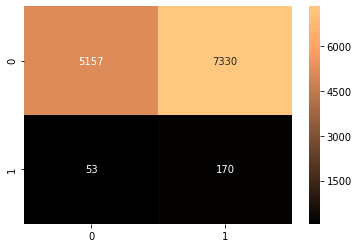

,param_clf__C,param_clf__class_weight,param_clf__loss,param_clf__max_iter,param_clf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5e-05,{1: 7},squared_hinge,500,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.317888,0.30572,0.285174,0.294692,0.291742,0.299043,0.011526,1
1,5e-05,{1: 7},squared_hinge,500,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.317888,0.30572,0.285174,0.294692,0.291742,0.299043,0.011526,1
2,5e-05,{1: 7},squared_hinge,500,60,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.317888,0.30572,0.285174,0.294692,0.291742,0.299043,0.011526,1
3,5e-05,{1: 7},squared_hinge,1000,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.317888,0.30572,0.285174,0.294692,0.291742,0.299043,0.011526,1
4,5e-05,{1: 7},squared_hinge,1000,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.317888,0.30572,0.285174,0.294692,0.291742,0.299043,0.011526,1


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124


Executed time: 34.31s

 ---------------------------------------- 
 2 MODELS - CONTROL MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LinearSVC 
 ----------------------------------------
Best parameters: 

 {'clf__C': 5e-05, 'clf__class_weight': {1: 7}, 'clf__loss': 'squared_hinge', 'clf__max_iter': 500, 'clf__random_state': 25} 

TRAIN GROUP

Cross-validation recall scores: [0.69082992 0.67259221 0.67228484]
Mean balanced accuracy score: 0.6785689890710382

TEST GROUP

Balanced Accuracy Score: 0.49941084639249067 

              precision    recall  f1-score   support

           0       0.99      0.44      0.61     12571
           1       0.01      0.56      0.01        80

    accuracy                           0.44     12651
   macro avg       0.50      0.50      0.31     12651
weighted avg       0.99      0.44      0.60     12651



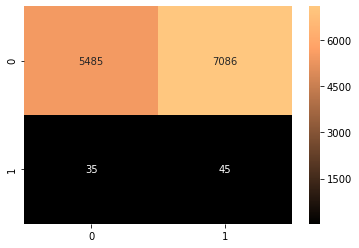

,param_clf__C,param_clf__class_weight,param_clf__loss,param_clf__max_iter,param_clf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5e-05,{1: 7},squared_hinge,500,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.324488,0.300431,0.294224,0.289724,0.285186,0.298811,0.013793,1
1,5e-05,{1: 7},squared_hinge,500,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.324488,0.300431,0.294224,0.289724,0.285186,0.298811,0.013793,1
2,5e-05,{1: 7},squared_hinge,500,60,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.324488,0.300431,0.294224,0.289724,0.285186,0.298811,0.013793,1
3,5e-05,{1: 7},squared_hinge,1000,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.324488,0.300431,0.294224,0.289724,0.285186,0.298811,0.013793,1
4,5e-05,{1: 7},squared_hinge,1000,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.324488,0.300431,0.294224,0.289724,0.285186,0.298811,0.013793,1


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403


Executed time: 31.73s


In [30]:
# MODEL 1 - LinearSVC()

params_LSVC = {
    'clf__loss' : ['squared_hinge'],
    'clf__C': [5e-5, 5e-6],
    'clf__random_state' : [25, 42, 60],
    'clf__max_iter' : [500, 1000],
    'clf__class_weight' : [{1 : 7}, {1 : 8}],   
    }

clf_LSVC = LinearSVC()

model_lists['LinearSVC_treat_2models'] = score_optimization(model="2 models - treatment", clf=clf_LSVC, params=params_LSVC,
                   X_train=X_treat_train, y_train=y_treat_train, 
                   X_test=X_treat_test, y_test=y_treat_test)

model_lists['LinearSVC_ctrl_2models'] = score_optimization(model="2 models - control", clf=clf_LSVC, params=params_LSVC,
                   X_train=X_ctrl_train, y_train=y_ctrl_train, 
                   X_test=X_ctrl_test, y_test=y_ctrl_test)


 ---------------------------------------- 
 2 MODELS - TREATMENT MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'clf__C': 1000.0, 'clf__class_weight': {1: 10}, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'saga', 'clf__tol': 1} 

TRAIN GROUP

Cross-validation recall scores: [0.80918819 0.79689171 0.78534767]
Mean balanced accuracy score: 0.7971425223296128

TEST GROUP

Balanced Accuracy Score: 0.5515921311527217 

              precision    recall  f1-score   support

           0       0.99      0.57      0.72     12487
           1       0.02      0.54      0.04       223

    accuracy                           0.56     12710
   macro avg       0.50      0.55      0.38     12710
weighted avg       0.97      0.56      0.71     12710



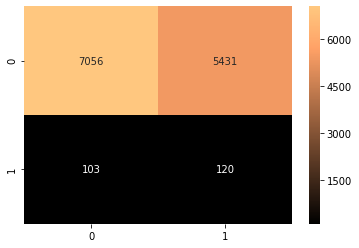

,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__random_state,param_clf__solver,param_clf__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1000,{1: 10},l2,42,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.448888,0.369577,0.473242,0.388377,0.420275,0.420072,0.037979,1
31,10000,{1: 10},l2,42,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.448888,0.369577,0.473242,0.388377,0.420275,0.420072,0.037979,1
34,10000,{1: 10},l2,60,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.379354,0.430977,0.416871,0.426505,0.417120,0.414165,0.018236,3
7,1000,{1: 10},l2,60,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.379354,0.430977,0.416871,0.426505,0.417120,0.414165,0.018236,3
32,10000,{1: 10},l2,42,newton-cg,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.440358,0.411872,0.399413,0.398199,0.398366,0.409642,0.016194,5


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351


Executed time: 72.12s

 ---------------------------------------- 
 2 MODELS - CONTROL MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'clf__C': 1000.0, 'clf__class_weight': {1: 10}, 'clf__penalty': 'l2', 'clf__random_state': 25, 'clf__solver': 'newton-cg', 'clf__tol': 1} 

TRAIN GROUP

Cross-validation recall scores: [0.80896516 0.78678279 0.7852459 ]
Mean balanced accuracy score: 0.7936646174863388

TEST GROUP

Balanced Accuracy Score: 0.4971412377694694 

              precision    recall  f1-score   support

           0       0.99      0.62      0.76     12571
           1       0.01      0.38      0.01        80

    accuracy                           0.62     12651
   macro avg       0.50      0.50      0.39     12651
weighted avg       0.99      0.62      0.76     12651



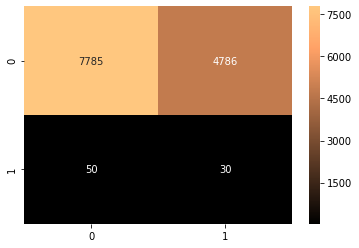

,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__random_state,param_clf__solver,param_clf__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
32,10000,{1: 10},l2,42,newton-cg,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.504807,0.481237,0.471188,0.469992,0.464391,0.478323,0.014313,1
2,1000,{1: 10},l2,25,newton-cg,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.504807,0.481237,0.471188,0.469992,0.464391,0.478323,0.014313,1
5,1000,{1: 10},l2,42,newton-cg,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.504807,0.481237,0.471188,0.469992,0.464391,0.478323,0.014313,1
29,10000,{1: 10},l2,25,newton-cg,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.504807,0.481237,0.471188,0.469992,0.464391,0.478323,0.014313,1
8,1000,{1: 10},l2,60,newton-cg,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.504807,0.481237,0.471188,0.469992,0.464391,0.478323,0.014313,1


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351
LogisticRegression_2 models - control,0.793665,0.497141,0.619282,0.375,0.376533


Executed time: 71.89s


In [31]:
# MODEL 2 - LogisticRegression()

params_LR = [{
    'clf__solver': ['liblinear','saga', 'newton-cg'],
    'clf__C': [1e3, 1e4],
    'clf__penalty': ['l2'],
    'clf__random_state' : [25, 42, 60],
    'clf__class_weight': [{1 : 10}, {1 : 25}, {1 : 50}],
    'clf__tol' : [1]
}]

clf_LR = LogisticRegression(
    n_jobs=1 # Use all CPU
)

model_lists['LogisticRegression_treat_2models'] = score_optimization(model="2 models - treatment", clf=clf_LR,params=params_LR,X_train=X_treat_train, 
                   y_train=y_treat_train, X_test=X_treat_test, y_test=y_treat_test)
model_lists['LogisticRegression_ctrl_2models'] = score_optimization(model="2 models - control",clf=clf_LR,params=params_LR,X_train=X_ctrl_train, 
                   y_train=y_ctrl_train, X_test=X_ctrl_test, y_test=y_ctrl_test)


 ---------------------------------------- 
 2 MODELS - TREATMENT MODEL 
 ----------------------------------------

 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best parameters: 

 {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 150} 

TRAIN GROUP

Cross-validation recall scores: [0.81422986 0.80882503 0.816066  ]
Mean balanced accuracy score: 0.8130402959365908

TEST GROUP

Balanced Accuracy Score: 0.5901944300099009 

              precision    recall  f1-score   support

           0       0.99      0.70      0.82     12487
           1       0.03      0.48      0.05       223

    accuracy                           0.69     12710
   macro avg       0.51      0.59      0.43     12710
weighted avg       0.97      0.69      0.80     12710



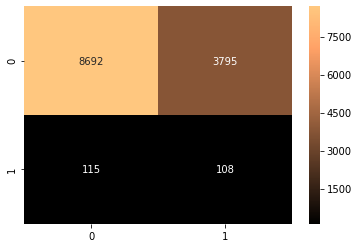

,param_clf__learning_rate,param_clf__max_depth,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.01,5,5,150,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.536747,0.547875,0.526826,0.535924,0.535165,0.536508,0.006710,1
8,0.01,5,2,150,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.536747,0.547875,0.526826,0.535924,0.535165,0.536508,0.006710,1
10,0.01,5,5,100,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.497014,0.514931,0.489852,0.510719,0.500673,0.502638,0.009115,3
7,0.01,5,2,100,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.497014,0.514931,0.489852,0.510719,0.500673,0.502638,0.009115,3
2,0.01,3,2,150,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.485596,0.493355,0.485706,0.492051,0.478794,0.487100,0.005231,5


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351
LogisticRegression_2 models - control,0.793665,0.497141,0.619282,0.375,0.376533
GradientBoostingClassifier_2 models - treatment,0.81304,0.590194,0.696084,0.484305,0.459023


Executed time: 1133.54s

 ---------------------------------------- 
 2 MODELS - CONTROL MODEL 
 ----------------------------------------

 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best parameters: 

 {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 150} 

TRAIN GROUP

Cross-validation recall scores: [0.9397541  0.95251025 0.9491291 ]
Mean balanced accuracy score: 0.9471311475409836

TEST GROUP

Balanced Accuracy Score: 0.4951475618486994 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12571
           1       0.00      0.00      0.00        80

    accuracy                           0.98     12651
   macro avg       0.50      0.50      0.50     12651
weighted avg       0.99      0.98      0.99     12651



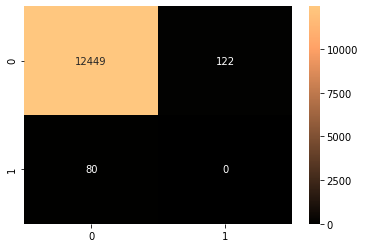

,param_clf__learning_rate,param_clf__max_depth,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.01,5,5,150,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.771047,0.771525,0.775538,0.776827,0.779705,0.774928,0.003269,1
8,0.01,5,2,150,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.771047,0.771525,0.775491,0.776827,0.779705,0.774919,0.003268,2
10,0.01,5,5,100,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.744839,0.754538,0.748100,0.758585,0.751772,0.751567,0.004804,3
7,0.01,5,2,100,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.744839,0.754538,0.748100,0.758585,0.751772,0.751567,0.004804,3
6,0.01,5,2,50,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.693101,0.679269,0.702668,0.712398,0.702856,0.698058,0.011203,5


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351
LogisticRegression_2 models - control,0.793665,0.497141,0.619282,0.375,0.376533
GradientBoostingClassifier_2 models - treatment,0.81304,0.590194,0.696084,0.484305,0.459023
GradientBoostingClassifier_2 models - control,0.947131,0.495148,0.990295,0,0.616993


Executed time: 1029.36s


In [32]:
# MODEL 3 - GradientBoostingClassifier()

params_GBC = [{
    'clf__learning_rate' : [1e-2, 1e-4],
    'clf__n_estimators' : [50,100,150],
    'clf__max_depth' : [3,5],
    'clf__min_samples_split' : [2, 5]
}]

clf_GBC = GradientBoostingClassifier()

model_lists['GradientBoostingClassifier_treat_2models'] = score_optimization(model="2 models - treatment", clf=clf_GBC,params=params_GBC,X_train=X_treat_train, 
                   y_train=y_treat_train, X_test=X_treat_test, y_test=y_treat_test)
model_lists['GradientBoostingClassifier_ctrl_2models'] = score_optimization(model="2 models - control",clf=clf_GBC,params=params_GBC,X_train=X_ctrl_train, 
                   y_train=y_ctrl_train, X_test=X_ctrl_test, y_test=y_ctrl_test)

In average, the GradientBoostingClassifier model seems to be the best one. 
- Best show case in Specificity and from our Optimize scorer.
- Best Balanced Accurarcy score also.

In [33]:
# PICKING UP BEST MODEL
best_model_treat = model_lists['GradientBoostingClassifier_treat_2models']
best_model_ctrl = model_lists['GradientBoostingClassifier_ctrl_2models']

In [34]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # CREATING DUMMIES VARIABLES FOR THE CATEGORICAL VARIABLES

    for feature in cat_features:
        df_dummies = pd.get_dummies(test[feature]).rename(columns=lambda x: feature + "_" + str(x))
        test = pd.concat([test, df_dummies], axis=1)
        test = test.drop(feature, axis=1)
    
    pred_probs_ctrl = best_model_ctrl.predict_proba(test)

    pred_probs_treat = best_model_treat.predict_proba(test)

    # get difference in probabilities between experimental and control model for purchase = 1 label
    lift = abs(pred_probs_treat[:,1] - pred_probs_ctrl[:,1])

    promotion = []
    
    # Only send promotions to top 3 percentile of probabilities
    cutoff_lift = np.percentile(lift, 97)
    
    for prob in lift:
        if prob > 0:
            if prob > cutoff_lift:
                promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [35]:
# THIS FUNCTION TESTS THE RESULTS OF THE PROMOTION STRATEGY.

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0116.

Your nir with this strategy is -21.50.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.011629098360655739, -21.5)

In this example, a manual search was conducted for simplicity sake. The performance of this model left a lot to be desired. Sending out promotions to individuals with lift values above the 97th percentile seems to be one of the better option. An irr of 1.17\% and nlr of \\$-20.90 is achieved for the test data, which is not as good as the Starbuck's model. It should also be noted that this method is extremely sensitive to changes in the cut-off percentile used for this dataset. Both the addition or subtraction of a few percentiles resulted in drastically different nlr. Hence, the two model approach is not recommended for this data set.

## III. 2. Considering 1 model; customers in promotion who purchased considered

In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. In other words, we want the model to find the individuals who are likely to purchase only after they received a promotion.

In [36]:
# CONSIDERING THE DATAFRAME
train_data_1model = train_data.copy()

train_data_1model['Confirmed'] = 0

# INDIVIDUS WHO BOUGHT THE PRODUCT WHEN INTO PROMOTION
train_data_1model.loc[train_data_1model[(train_data_1model['Promotion'] == 'Yes') & (train_data_1model['purchase'] == 1)].index, 'Confirmed'] = 1

In [37]:
features = ['V2', 'V3', 'V1_0', 'V1_1', 'V1_2',
            'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2',
            'V5_3', 'V5_4', 'V6_1', 'V6_2','V6_3',
            'V6_4', 'V7_1', 'V7_2']

# X,y
X = train_data_1model[features]
y = train_data_1model['Confirmed']

# SPLITTING DATA INTO TRAIN/VALIDATE DATAFRAMES FOR BOTH MODELS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [38]:
# BALANCING THE DATA
smt = SMOTE()

X_train, y_train = smt.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=features)
y_train = pd.Series(y_train)


 ---------------------------------------- 
 1 MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LinearSVC 
 ----------------------------------------
Best parameters: 

 {'clf__C': 5e-05, 'clf__class_weight': {1: 7}, 'clf__loss': 'squared_hinge', 'clf__max_iter': 500, 'clf__random_state': 25} 

TRAIN GROUP

Cross-validation recall scores: [0.69840428 0.68859646 0.68808489]
Mean balanced accuracy score: 0.6916952096361957

TEST GROUP

Balanced Accuracy Score: 0.5974377204095991 

              precision    recall  f1-score   support

           0       1.00      0.43      0.60     25147
           1       0.01      0.77      0.02       214

    accuracy                           0.43     25361
   macro avg       0.50      0.60      0.31     25361
weighted avg       0.99      0.43      0.59     25361



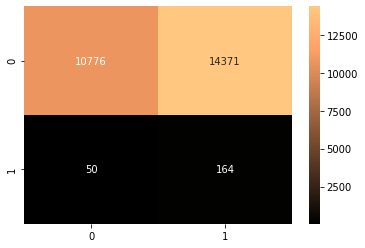

,param_clf__C,param_clf__class_weight,param_clf__loss,param_clf__max_iter,param_clf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5e-05,{1: 7},squared_hinge,500,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.323325,0.306897,0.305369,0.3056,0.304487,0.309136,0.007136,1
1,5e-05,{1: 7},squared_hinge,500,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.323325,0.306897,0.305369,0.3056,0.304487,0.309136,0.007136,1
2,5e-05,{1: 7},squared_hinge,500,60,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.323325,0.306897,0.305369,0.3056,0.304487,0.309136,0.007136,1
3,5e-05,{1: 7},squared_hinge,1000,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.323325,0.306897,0.305369,0.3056,0.304487,0.309136,0.007136,1
4,5e-05,{1: 7},squared_hinge,1000,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.323325,0.306897,0.305369,0.3056,0.304487,0.309136,0.007136,1


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351
LogisticRegression_2 models - control,0.793665,0.497141,0.619282,0.375,0.376533
GradientBoostingClassifier_2 models - treatment,0.81304,0.590194,0.696084,0.484305,0.459023
GradientBoostingClassifier_2 models - control,0.947131,0.495148,0.990295,0,0.616993
LinearSVC_1,0.691695,0.597438,0.42852,0.766355,0.287641


Executed time: 59.93s


In [39]:
# MODEL 1 - LinearSVC()

model_lists['LinearSVC_1model'] = score_optimization(model="1", clf=clf_LSVC, params=params_LSVC,
                   X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test)


 ---------------------------------------- 
 1 MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'clf__C': 1000.0, 'clf__class_weight': {1: 10}, 'clf__penalty': 'l2', 'clf__random_state': 25, 'clf__solver': 'saga', 'clf__tol': 1} 

TRAIN GROUP

Cross-validation recall scores: [0.76751253 0.72656647 0.77824086]
Mean balanced accuracy score: 0.7574399539023983

TEST GROUP

Balanced Accuracy Score: 0.6020262538516513 

              precision    recall  f1-score   support

           0       0.99      0.55      0.71     25147
           1       0.01      0.65      0.02       214

    accuracy                           0.55     25361
   macro avg       0.50      0.60      0.37     25361
weighted avg       0.99      0.55      0.70     25361



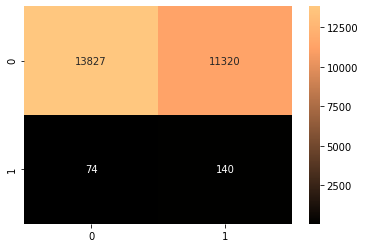

,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__random_state,param_clf__solver,param_clf__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1000,{1: 10},l2,25,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.365964,0.365222,0.488628,0.433393,0.419456,0.414533,0.046175,1
28,10000,{1: 10},l2,25,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.365964,0.365222,0.488628,0.433393,0.419456,0.414533,0.046175,1
4,1000,{1: 10},l2,42,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.419294,0.401074,0.395892,0.415629,0.373862,0.401150,0.016193,3
31,10000,{1: 10},l2,42,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.419294,0.401074,0.395892,0.415629,0.373862,0.401150,0.016193,3
32,10000,{1: 10},l2,42,newton-cg,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.419556,0.394198,0.395434,0.393525,0.393177,0.399178,0.010218,5


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351
LogisticRegression_2 models - control,0.793665,0.497141,0.619282,0.375,0.376533
GradientBoostingClassifier_2 models - treatment,0.81304,0.590194,0.696084,0.484305,0.459023
GradientBoostingClassifier_2 models - control,0.947131,0.495148,0.990295,0,0.616993
LinearSVC_1,0.691695,0.597438,0.42852,0.766355,0.287641
LogisticRegression_1,0.75744,0.602026,0.549847,0.654206,0.368110


Executed time: 153.69s


In [40]:
# MODEL 2 - LogisticRegression()

model_lists['LogisticRegression_1model'] = score_optimization(model="1", clf=clf_LR, params=params_LR,
                   X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test)


 ---------------------------------------- 
 1 MODEL 
 ----------------------------------------

 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best parameters: 

 {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 150} 

TRAIN GROUP

Cross-validation recall scores: [0.82140823 0.82027806 0.82518537]
Mean balanced accuracy score: 0.822290555610266

TEST GROUP

Balanced Accuracy Score: 0.5982811721284454 

              precision    recall  f1-score   support

           0       0.99      0.72      0.83     25147
           1       0.01      0.48      0.03       214

    accuracy                           0.72     25361
   macro avg       0.50      0.60      0.43     25361
weighted avg       0.99      0.72      0.83     25361



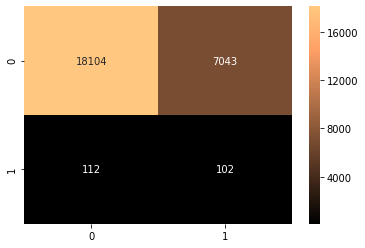

,param_clf__learning_rate,param_clf__max_depth,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.01,5,5,150,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.553090,0.569542,0.541334,0.551698,0.549636,0.553060,0.009195,1
8,0.01,5,2,150,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.553090,0.569542,0.541334,0.551698,0.549636,0.553060,0.009195,1
10,0.01,5,5,100,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.502395,0.506236,0.494850,0.512034,0.497867,0.502677,0.006078,3
7,0.01,5,2,100,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.502395,0.506236,0.494850,0.512034,0.497867,0.502677,0.006078,3
9,0.01,5,5,50,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.485693,0.492713,0.450492,0.486325,0.489591,0.480963,0.015441,5


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351
LogisticRegression_2 models - control,0.793665,0.497141,0.619282,0.375,0.376533
GradientBoostingClassifier_2 models - treatment,0.81304,0.590194,0.696084,0.484305,0.459023
GradientBoostingClassifier_2 models - control,0.947131,0.495148,0.990295,0,0.616993
LinearSVC_1,0.691695,0.597438,0.42852,0.766355,0.287641
LogisticRegression_1,0.75744,0.602026,0.549847,0.654206,0.368110
GradientBoostingClassifier_1,0.822291,0.598281,0.719927,0.476636,0.477351


Executed time: 2222.68s


In [41]:
# MODEL 3 - GradientBoostingClassifier()

model_lists['GradientBoostingClassifier_1model'] = score_optimization(model="1", clf=clf_GBC, params=params_GBC,
                   X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test)

Once more time, the GradientBoostingClassifier seems to outperform the other models. However; its execution time of training is largely superior than the other ones.

In [42]:
# PICKING UP BEST MODEL
best_model = model_lists['GradientBoostingClassifier_1model']

In [43]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # CREATING DUMMIES VARIABLES FOR THE CATEGORICAL VARIABLES

    for feature in cat_features:
        df_dummies = pd.get_dummies(test[feature]).rename(columns=lambda x: feature + "_" + str(x))
        test = pd.concat([test, df_dummies], axis=1)
        test = test.drop(feature, axis=1)
    
    y_preds = best_model.predict(test)

    promotion = []
    
    for pred in y_preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [44]:
# THIS FUNCTION TESTS THE RESULTS OF THE PROMOTION STRATEGY.

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0217.

Your nir with this strategy is 376.25.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.021689556509299, 376.25)

This unique model approach outperforms Starbucks' strategy with an irr of 2.11% and nir of $340.20. The assigning of this "Confirmed" label to some users might have been luck but overall results are very optimistic.

## III. 3. Considering 1 model; no distinguish between treatment and control

Here, we apply simply our model to the list of features without being any distinguish between a purchaser in the experiment or not.

In [45]:
# CONSIDERING THE DATAFRAME
train_data_simple_model = train_data.copy()

features = ['V2', 'V3', 'V1_0', 'V1_1', 'V1_2',
            'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2',
            'V5_3', 'V5_4', 'V6_1', 'V6_2','V6_3',
            'V6_4', 'V7_1', 'V7_2']

# X,y
X = train_data_simple_model[features]
y = train_data_simple_model['purchase']

# SPLITTING DATA INTO TRAIN/VALIDATE DATAFRAMES FOR BOTH MODELS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# BALANCING THE DATA
smt = SMOTE()

X_train, y_train = smt.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=features)
y_train = pd.Series(y_train)


 ---------------------------------------- 
 SIMPLE MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LinearSVC 
 ----------------------------------------
Best parameters: 

 {'clf__C': 5e-05, 'clf__class_weight': {1: 7}, 'clf__loss': 'squared_hinge', 'clf__max_iter': 500, 'clf__random_state': 25} 

TRAIN GROUP

Cross-validation recall scores: [0.65169635 0.63691408 0.64105346]
Mean balanced accuracy score: 0.6432212966273892

TEST GROUP

Balanced Accuracy Score: 0.5452301099310601 

              precision    recall  f1-score   support

           0       0.99      0.33      0.49     25046
           1       0.01      0.76      0.03       315

    accuracy                           0.33     25361
   macro avg       0.50      0.55      0.26     25361
weighted avg       0.98      0.33      0.49     25361



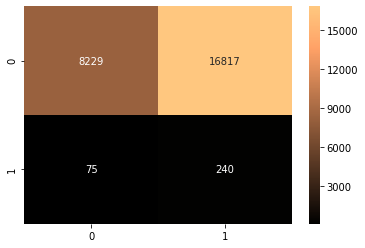

,param_clf__C,param_clf__class_weight,param_clf__loss,param_clf__max_iter,param_clf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5e-05,{1: 7},squared_hinge,500,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.25084,0.223631,0.221488,0.227216,0.226936,0.230022,0.010625,1
1,5e-05,{1: 7},squared_hinge,500,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.25084,0.223631,0.221488,0.227216,0.226936,0.230022,0.010625,1
2,5e-05,{1: 7},squared_hinge,500,60,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.25084,0.223631,0.221488,0.227216,0.226936,0.230022,0.010625,1
3,5e-05,{1: 7},squared_hinge,1000,25,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.25084,0.223631,0.221488,0.227216,0.226936,0.230022,0.010625,1
4,5e-05,{1: 7},squared_hinge,1000,42,"{'clf__C': 5e-05, 'clf__class_weight': {1: 7},...",0.25084,0.223631,0.221488,0.227216,0.226936,0.230022,0.010625,1


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351
LogisticRegression_2 models - control,0.793665,0.497141,0.619282,0.375,0.376533
GradientBoostingClassifier_2 models - treatment,0.81304,0.590194,0.696084,0.484305,0.459023
GradientBoostingClassifier_2 models - control,0.947131,0.495148,0.990295,0,0.616993
LinearSVC_1,0.691695,0.597438,0.42852,0.766355,0.287641
LogisticRegression_1,0.75744,0.602026,0.549847,0.654206,0.368110
GradientBoostingClassifier_1,0.822291,0.598281,0.719927,0.476636,0.477351
LinearSVC_simple,0.643221,0.54523,0.328555,0.761905,0.204392


Executed time: 58.91s


In [46]:
# MODEL 1 - LinearSVC()

model_lists['LinearSVC_simple'] = score_optimization(model="simple", clf=clf_LSVC, params=params_LSVC,
                   X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test)


 ---------------------------------------- 
 SIMPLE MODEL 
 ----------------------------------------

 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'clf__C': 1000.0, 'clf__class_weight': {1: 10}, 'clf__penalty': 'l2', 'clf__random_state': 25, 'clf__solver': 'saga', 'clf__tol': 1} 

TRAIN GROUP

Cross-validation recall scores: [0.74313504 0.71839491 0.69949228]
Mean balanced accuracy score: 0.7203407437212066

TEST GROUP

Balanced Accuracy Score: 0.5451240827987615 

              precision    recall  f1-score   support

           0       0.99      0.42      0.59     25046
           1       0.01      0.67      0.03       315

    accuracy                           0.42     25361
   macro avg       0.50      0.55      0.31     25361
weighted avg       0.98      0.42      0.58     25361



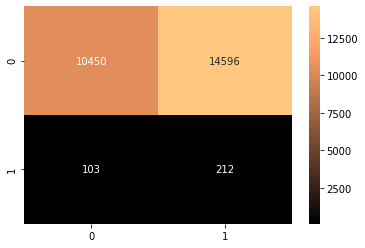

,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__random_state,param_clf__solver,param_clf__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1000,{1: 10},l2,25,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.371178,0.380254,0.363026,0.259398,0.252143,0.325200,0.056996,1
28,10000,{1: 10},l2,25,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.371178,0.380254,0.363026,0.259398,0.252143,0.325200,0.056996,1
34,10000,{1: 10},l2,60,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.309769,0.338862,0.297010,0.352582,0.298349,0.319314,0.022436,3
7,1000,{1: 10},l2,60,saga,1,"{'clf__C': 1000.0, 'clf__class_weight': {1: 10...",0.309769,0.338862,0.297010,0.352582,0.298349,0.319314,0.022436,3
31,10000,{1: 10},l2,42,saga,1,"{'clf__C': 10000.0, 'clf__class_weight': {1: 1...",0.351337,0.263071,0.298546,0.314232,0.354088,0.316255,0.034083,5


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351
LogisticRegression_2 models - control,0.793665,0.497141,0.619282,0.375,0.376533
GradientBoostingClassifier_2 models - treatment,0.81304,0.590194,0.696084,0.484305,0.459023
GradientBoostingClassifier_2 models - control,0.947131,0.495148,0.990295,0,0.616993
LinearSVC_1,0.691695,0.597438,0.42852,0.766355,0.287641
LogisticRegression_1,0.75744,0.602026,0.549847,0.654206,0.368110
GradientBoostingClassifier_1,0.822291,0.598281,0.719927,0.476636,0.477351
LinearSVC_simple,0.643221,0.54523,0.328555,0.761905,0.204392


Executed time: 143.28s


In [47]:
# MODEL 2 - LogisticRegression()

model_lists['LogisticRegression_simple'] = score_optimization(model="simple", clf=clf_LR, params=params_LR,
                   X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test)


 ---------------------------------------- 
 SIMPLE MODEL 
 ----------------------------------------

 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best parameters: 

 {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 150} 

TRAIN GROUP

Cross-validation recall scores: [0.81630139 0.82661529 0.82366074]
Mean balanced accuracy score: 0.8221924732116682

TEST GROUP

Balanced Accuracy Score: 0.5566899127827021 

              precision    recall  f1-score   support

           0       0.99      0.77      0.86     25046
           1       0.02      0.35      0.03       315

    accuracy                           0.76     25361
   macro avg       0.50      0.56      0.45     25361
weighted avg       0.98      0.76      0.85     25361



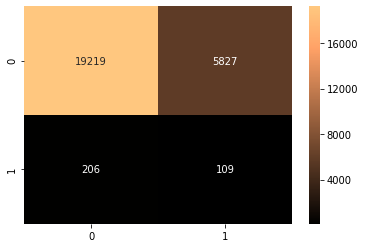

,param_clf__learning_rate,param_clf__max_depth,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.01,5,5,150,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.58090,0.593617,0.574070,0.588521,0.583217,0.584065,0.006659,1
8,0.01,5,2,150,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.58090,0.593617,0.574070,0.588521,0.583217,0.584065,0.006659,1
21,0.0001,5,5,50,"{'clf__learning_rate': 0.0001, 'clf__max_depth...",0.52589,0.529275,0.529354,0.532345,0.531442,0.529661,0.002229,3
18,0.0001,5,2,50,"{'clf__learning_rate': 0.0001, 'clf__max_depth...",0.52589,0.529275,0.529354,0.532345,0.531442,0.529661,0.002229,3
19,0.0001,5,2,100,"{'clf__learning_rate': 0.0001, 'clf__max_depth...",0.52589,0.529275,0.529354,0.531776,0.531442,0.529547,0.002100,5


,Train_Balanced_Accuracy,Test_Balanced_Accuracy,Test_Specification,Test_Recall,Optimize
LinearSVC_2 models - treatment,0.687577,0.587661,0.41299,0.762332,0.274124
LinearSVC_2 models - control,0.678569,0.499411,0.436322,0.5625,0.258403
LogisticRegression_2 models - treatment,0.797143,0.551592,0.565068,0.538117,0.360351
LogisticRegression_2 models - control,0.793665,0.497141,0.619282,0.375,0.376533
GradientBoostingClassifier_2 models - treatment,0.81304,0.590194,0.696084,0.484305,0.459023
GradientBoostingClassifier_2 models - control,0.947131,0.495148,0.990295,0,0.616993
LinearSVC_1,0.691695,0.597438,0.42852,0.766355,0.287641
LogisticRegression_1,0.75744,0.602026,0.549847,0.654206,0.368110
GradientBoostingClassifier_1,0.822291,0.598281,0.719927,0.476636,0.477351
LinearSVC_simple,0.643221,0.54523,0.328555,0.761905,0.204392


Executed time: 2216.06s


In [48]:
# MODEL 3 - GradientBoostingClassifier()

model_lists['GradientBoostingClassifier_simple'] = score_optimization(model="simple", clf=clf_GBC, params=params_GBC,
                   X_train=X_train, y_train=y_train, 
                   X_test=X_test, y_test=y_test)

GradientBoostingClassifier is our best model.

In [49]:
# PICKING UP BEST MODEL
best_model = model_lists['GradientBoostingClassifier_simple']

In [50]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # CREATING DUMMIES VARIABLES FOR THE CATEGORICAL VARIABLES

    for feature in cat_features:
        df_dummies = pd.get_dummies(test[feature]).rename(columns=lambda x: feature + "_" + str(x))
        test = pd.concat([test, df_dummies], axis=1)
        test = test.drop(feature, axis=1)
    
    y_preds = best_model.predict(test)

    promotion = []
    
    for pred in y_preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [51]:
# THIS FUNCTION TESTS THE RESULTS OF THE PROMOTION STRATEGY.

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0213.

Your nir with this strategy is 279.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.02126449776548202, 279.6)

This was the simplest model to implement. There was no distinguish between a user who bought in the experiment or not. It finishes with an irr of 2.08% and an nir of $250. This is slighty less than the other 1 model approach but it remains still superior than the Starbucks' model.

Comparing feature importances between the last 2 approaches.

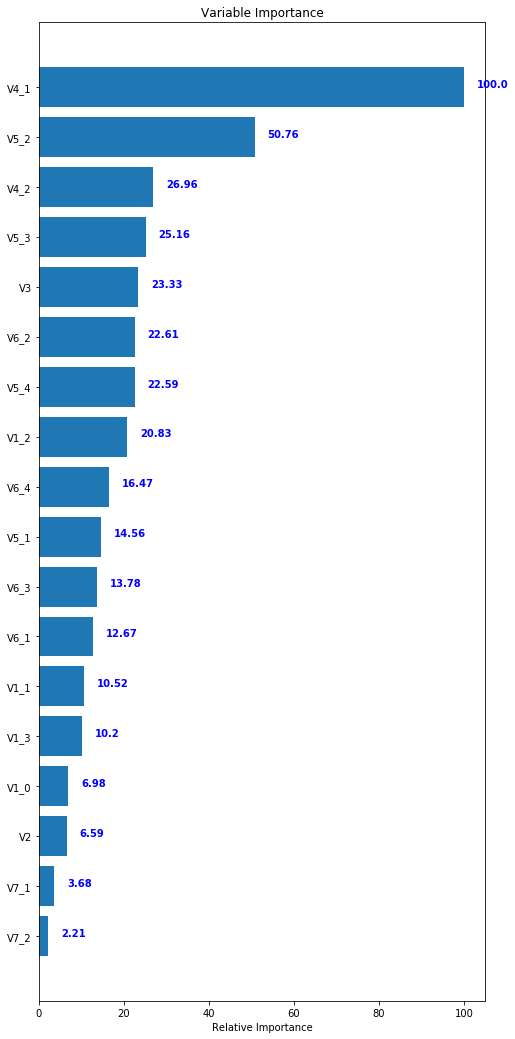

In [85]:
# Plot feature importance https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
feature_importance_1model = model_lists['GradientBoostingClassifier_1model']['clf'].feature_importances_
# make importances relative to max importance
feature_importance_1model = 100.0 * (feature_importance_1model / feature_importance_1model.max())
sorted_idx_1model = np.argsort(feature_importance_1model)
pos = np.arange(sorted_idx_1model.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance_1model[sorted_idx_1model], align='center')
plt.yticks(pos, X.keys()[sorted_idx_1model])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
for i, v in enumerate(feature_importance_1model[sorted_idx_1model]):
    plt.text(v + 3, i + 0.5, str(round(v,2)), color='blue', fontweight='bold')

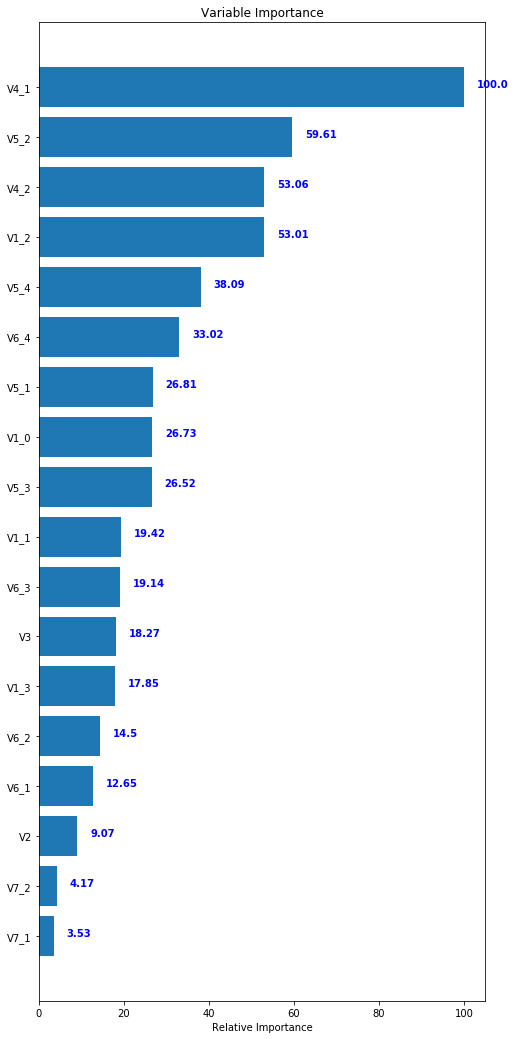

In [111]:
# Plot feature importance https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
feature_importance_simple = model_lists['GradientBoostingClassifier_simple']['clf'].feature_importances_
# make importances relative to max importance
feature_importance_simple = 100.0 * (feature_importance_simple / feature_importance_simple.max())
sorted_idx_simple = np.argsort(feature_importance_simple)
pos = np.arange(sorted_idx_simple.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance_simple[sorted_idx_simple], align='center')
plt.yticks(pos, X.keys()[sorted_idx_simple])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
for i, v in enumerate(feature_importance_simple[sorted_idx_simple]):
    plt.text(v + 3, i + 0.5, str(round(v,2)), color='blue', fontweight='bold')

Text(0.5, 1.0, 'Variable Importance - simple model')

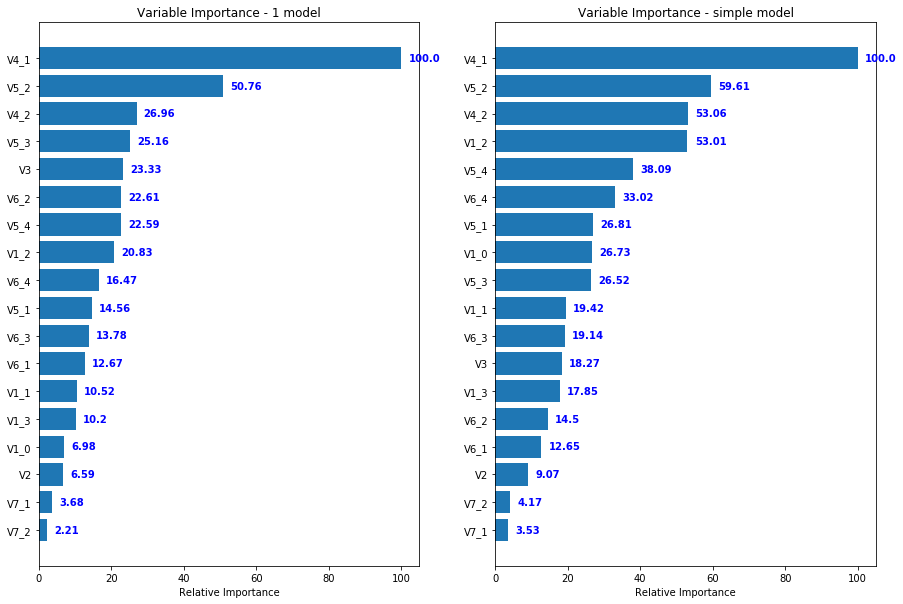

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

feature_importance_simple = model_lists['GradientBoostingClassifier_simple']['clf'].feature_importances_
# make importances relative to max importance
feature_importance_simple = 100.0 * (feature_importance_simple / feature_importance_simple.max())
sorted_idx_simple = np.argsort(feature_importance_simple)
pos_simple = np.arange(sorted_idx_simple.shape[0]) + .5

feature_importance_1model = model_lists['GradientBoostingClassifier_1model']['clf'].feature_importances_
# make importances relative to max importance
feature_importance_1model = 100.0 * (feature_importance_1model / feature_importance_1model.max())
sorted_idx_1model = np.argsort(feature_importance_1model)
pos_1model = np.arange(sorted_idx_1model.shape[0]) + .5

# figure 1 - features iportances - 1 model approach
ax[0].barh(pos, feature_importance_1model[sorted_idx_1model], align='center')
ax[0].set_xlabel('Relative Importance')
ax[0].set_yticklabels(X.keys()[sorted_idx_1model])
ax[0].set_yticks(pos_1model)
for i, v in enumerate(feature_importance_1model[sorted_idx_1model]):
    ax[0].text(v + 2, i + 0.4, str(round(v,2)), color='blue', fontweight='bold')
ax[0].set_title('Variable Importance - 1 model')
    
# figure 2 - features iportances - simple model approach
ax[1].barh(pos, feature_importance_simple[sorted_idx_simple], align='center')
ax[1].set_xlabel('Relative Importance')
ax[1].set_yticks(pos_simple)
ax[1].set_yticklabels(X.keys()[sorted_idx_simple])
for i, v in enumerate(feature_importance_simple[sorted_idx_simple]):
    ax[1].text(v + 2, i+0.4, str(round(v,2)), color='blue', fontweight='bold')
ax[1].set_title('Variable Importance - simple model')

In [92]:
feature_importance_simple[sorted_idx_simple]

array([  3.53410659,   4.17233734,   9.06761975,  12.64905279,
        14.49633354,  17.85348275,  18.26674824,  19.13621026,
        19.41602132,  26.52437387,  26.7268861 ,  26.81424524,
        33.01588653,  38.08614427,  53.01414395,  53.06113142,
        59.60677332, 100.        ])